# 0. Preparation

## (Optoinal) mount google drive
- Make sure that available access is the user's own drive(no access across files in shared folder)

In [5]:
if 'google.colab' in str(get_ipython()):
    IN_COLLAB = True
else:
    IN_COLLAB = False

if IN_COLLAB:
    #TODO: CHANGE THIS BASED ON YOUR OWN LOCAL SETTINGS
    MY_HOME_ABS_PATH = "/content/drive/MyDrive/W210/co2-flux-hourly-gpp-modeling"
    from google.colab import drive
    drive.mount('/content/drive/')
else:
    MY_HOME_ABS_PATH = "/root/co2-flux-hourly-gpp-modeling/"

## Import libraries

In [6]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
import copy
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pytorch_lightning as pl
import torch
import torch.nn as nn

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting import BaseModel, MAE
from pytorch_forecasting.metrics.point import RMSE
from pytorch_forecasting.data.encoders import NaNLabelEncoder

from sklearn.metrics import r2_score
from timeit import default_timer
from datetime import datetime
import gc
import pickle

# Load locale custome modules
os.chdir(MY_HOME_ABS_PATH)
if IN_COLLAB:
     sys.path.insert(0,os.path.abspath("./code/src/tools"))
else:
    sys.path.append('./.cred')
    sys.path.append('./code/src/tools')
    sys.path.append(os.path.abspath("./code/src/tools"))

from CloudIO.AzStorageClient import AzStorageClient
from data_pipeline_lib import *
from model_pipeline_lib import *

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pl.seed_everything(42)

Global seed set to 42


42

# Load data from Azure blob

In [7]:
# Download full data
root_dir  = MY_HOME_ABS_PATH
tmp_dir   = root_dir + os.sep + '.tmp'
model_dir = root_dir + os.sep + 'data' + os.sep + 'models'

container = "all-sites-data"
blob_name = "full_2010_2015_v_mvp_raw.parquet"
local_file = tmp_dir + os.sep + blob_name

data_df = get_raw_datasets(container, blob_name)

Data size: (4862712, 51)
Data Columns: Index(['GPP_NT_VUT_REF', 'site_id', 'timestep_idx_local',
       'timestep_idx_global', 'datetime', 'date', 'year', 'month', 'day',
       'hour', 'TA_ERA', 'SW_IN_ERA', 'LW_IN_ERA', 'VPD_ERA', 'P_ERA',
       'PA_ERA', 'EVI', 'NDVI', 'NIRv', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
       'b7', 'IGBP', 'lat', 'long', 'koppen_sub', 'koppen_main', 'c3c4',
       'c4_percent', 'BESS-PAR', 'BESS-PARdiff', 'BESS-RSDN', 'CSIF-SIFdaily',
       'PET', 'Ts', 'ESACCI-sm', 'MODIS_LC', 'NDWI', 'Percent_Snow', 'Fpar',
       'Lai', 'LST_Day', 'LST_Night', 'MODIS_IGBP', 'MODIS_PFT',
       'gap_flag_hour', 'gap_flag_month'],
      dtype='object')
NA count: 0


# Eval Model

In [8]:
exp_model_dir = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_12_2_gap_fill_tft_2Y_3D_230330_2239" # TODO: Replace to your model dir
best_model_path = "/root/co2-flux-hourly-gpp-modeling/data/models/tft_model_12_2_gap_fill_tft_2Y_3D_230330_2239/lightning_logs/version_0/checkpoints/epoch=7-step=39640.ckpt"
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
print(f"Quantiles: {best_tft.loss.quantiles}") # [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]

# Experiment constants
VAL_INDEX = 3
TEST_INDEX = 4
SUBSET_LEN = 24*365*2 # 1 year
ENCODER_LEN = 24*3
print(f"training timestemp length= {SUBSET_LEN}")

# create dataloaders for model
# ref: https://pytorch-lightning.readthedocs.io/en/stable/guides/speed.html#dataloaders
batch_size = 128  # set this between 32 to 128
cpu_count = os.cpu_count()

Quantiles: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
training timestemp length= 17520


In [9]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset_nogpp_slimfeatures(train_df, val_df, None, ENCODER_LEN)

Subest length: 17520 timesteps for each sites
Subset num train timesteps: 1287576
Subset num val timesteps: 446760


## Default Evaluation (1 year of validation data)

In [ ]:
# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

# Print Model Eval on Validation Set
start = default_timer()
print(f"Start eval on validation.")
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_q_predictions = best_tft.predict(val_dataloader, mode="quantiles", show_progress_bar=True, return_x=False)
eval_time = default_timer() - start
print(f"Val eval time: {eval_time}")

# save eval results - also we can resume eval at a later point in time
with open(exp_model_dir + os.sep + "val_actuals.pkl", "wb") as fout:
    pickle.dump(val_actuals, fout)

with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "wb") as fout:
    pickle.dump(val_q_predictions, fout)

Start eval on validation.


In [9]:
# load eval results - also we can resume eval at a later point in time
with open(exp_model_dir + os.sep + "val_actuals.pkl", "rb") as fin:
    val_acutals = pickle.load(fin)

with open(exp_model_dir + os.sep + "val_q_predictions.pkl", "rb") as fin:
    val_q_predictions = pickle.load(fin)

# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=cpu_count)

val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
val_p90 = val_q_predictions[:, :,5] # p90 == estimation
del val_q_predictions

# Unmasked evaltaion
eval_metric = get_eval_metrics(val_acutals, val_predictions, None, val_p90)
print(f"Unmasked Val eval evaluation: {eval_metric}")

# Masked evlationa
start = default_timer()
mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
masked_eval_metric = get_eval_metrics(val_acutals, val_predictions, mask, val_p90)
eval_time = default_timer() - start
print(f"Masked Val eval time: {eval_time}")
print(f"Masked Val eval evaluation: {masked_eval_metric}")

Unmasked Val eval evaluation: {'rmse': 3.805093288421631, 'mae': 2.100571632385254, 'nse': 0.7129441499710083, 'r2': 0.7129441446321314, 'p50_loss': 0.5059958100318909, 'p90_loss': 0.28087568283081055}
Masked Val eval time: 60.20832965699992
Masked Val eval evaluation: {'rmse': 3.8735005855560303, 'mae': 2.1550192832946777, 'nse': 0.7132317423820496, 'r2': 0.7132317345777428, 'p50_loss': 0.5156517624855042, 'p90_loss': 0.2865813076496124}


## Eval 5 Years of Validation Data

In [7]:
# split data
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, _, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset(train_df, val_df, None, ENCODER_LEN)
print(f"validation timesteps: {len(val_df)}")

del train_df
gc.collect()

# Eval on Validation set
val_dataloader = validation.to_dataloader(train=False, batch_size=128, num_workers=os.cpu_count())

start = default_timer()
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
val_q_predictions = best_tft.predict(val_dataloader, mode="quantiles", show_progress_bar=True)
print(f"Val eval time: {default_timer() - start}")

# save eval results - also we can resume tuning at a later point in time
with open(exp_model_dir + os.sep + "val5yr_actuals.pkl", "wb") as fout:
    pickle.dump(val_actuals, fout)

with open(exp_model_dir + os.sep + "val5yr_q_predictions.pkl", "wb") as fout:
    pickle.dump(val_q_predictions, fout)

Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760
validation timesteps: 1056072


Predict: 100%|██████████| 8236/8236 [48:15<00:00,  2.84 batches/s]


Val eval time: 2935.440092773999


In [8]:
# load eval results - also we can resume eval at a later point in time
with open(exp_model_dir + os.sep + "val5yr_actuals.pkl", "rb") as fin:
    val_acutals = pickle.load(fin)

with open(exp_model_dir + os.sep + "val5yr_q_predictions.pkl", "rb") as fin:
    val_q_predictions = pickle.load(fin)

val_predictions = val_q_predictions[:, :, 3] # p50 == estimation
val_p90 = val_q_predictions[:, :,5] # p90
#del val_q_predictions
    
# Unmasked evaltaion
eval_metric = get_eval_metrics(val_actuals, val_predictions, None, val_p90)
print(f"Unmasked Val eval evaluation: {eval_metric}")

# Masked evlationa
start = default_timer()
mask = torch.logical_not(torch.cat([x['decoder_cat'][:, :, -1].reshape(-1) for x, y in iter(val_dataloader)]))
masked_eval_metric = get_eval_metrics(val_actuals, val_predictions, mask, val_p90)
eval_time = default_timer() - start
print(f"Masked Val eval time: {eval_time}")
print(f"Masked Val eval evaluation: {masked_eval_metric}")

Unmasked Val eval evaluation: {'rmse': 3.5234787464141846, 'mae': 1.9313212633132935, 'nse': 0.7551763653755188, 'r2': 0.7551763949684984, 'p50_loss': 0.47519004344940186, 'p90_loss': 0.27348700165748596}
Masked Val eval time: 39.94905425199977
Masked Val eval evaluation: {'rmse': 3.6059839725494385, 'mae': 1.97890305519104, 'nse': 0.7560282349586487, 'r2': 0.7560282320771401, 'p50_loss': 0.4844796061515808, 'p90_loss': 0.2789272964000702}


# Model Interpreation

Subest length: 8760 timesteps for each sites
Subset num train timesteps: 683280
Subset num val timesteps: 227760


Predict: 100%|██████████| 3530/3530 [09:39<00:00,  6.09 batches/s]


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x1125 with 1 Axes>,
 'decoder_variables': <Figure size 700x1075 with 1 Axes>}

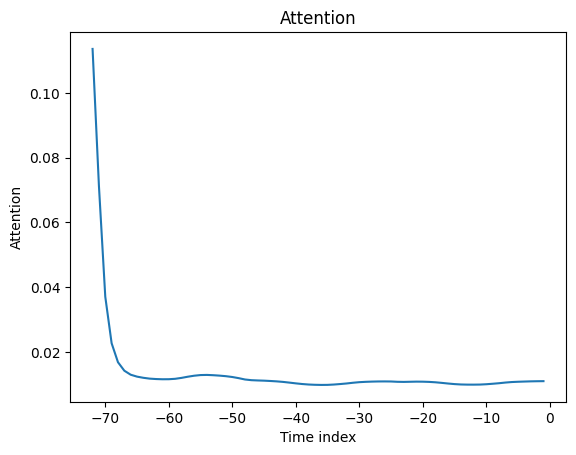

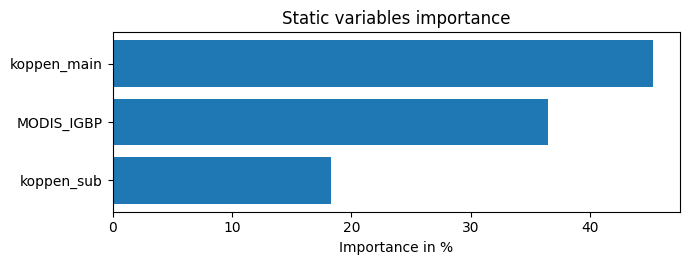

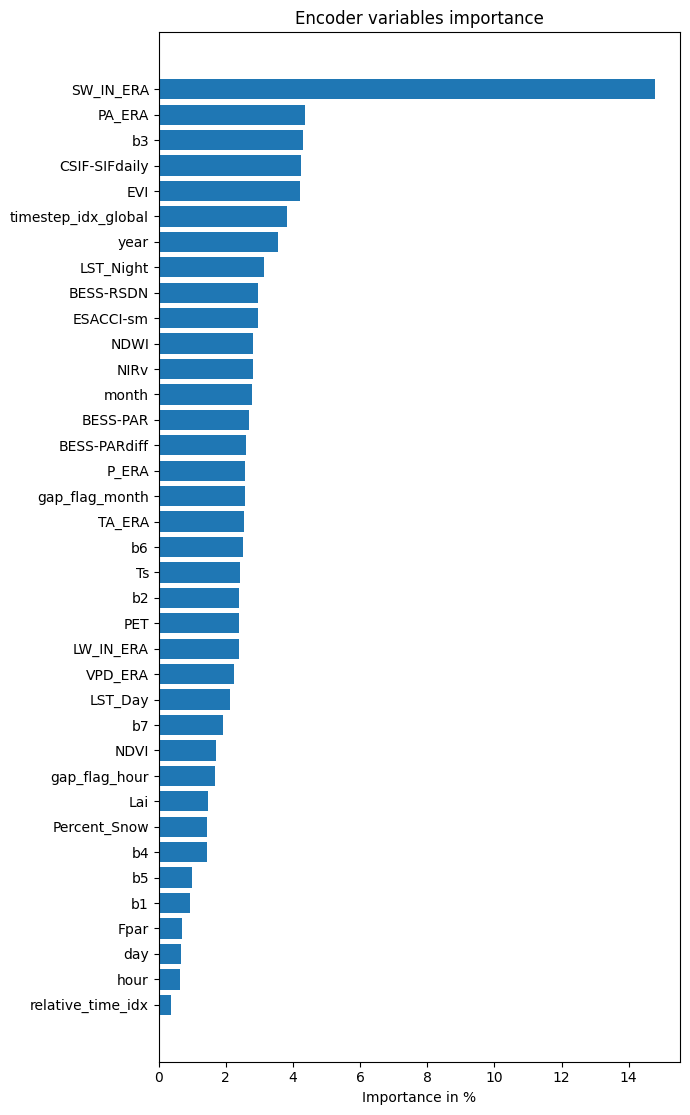

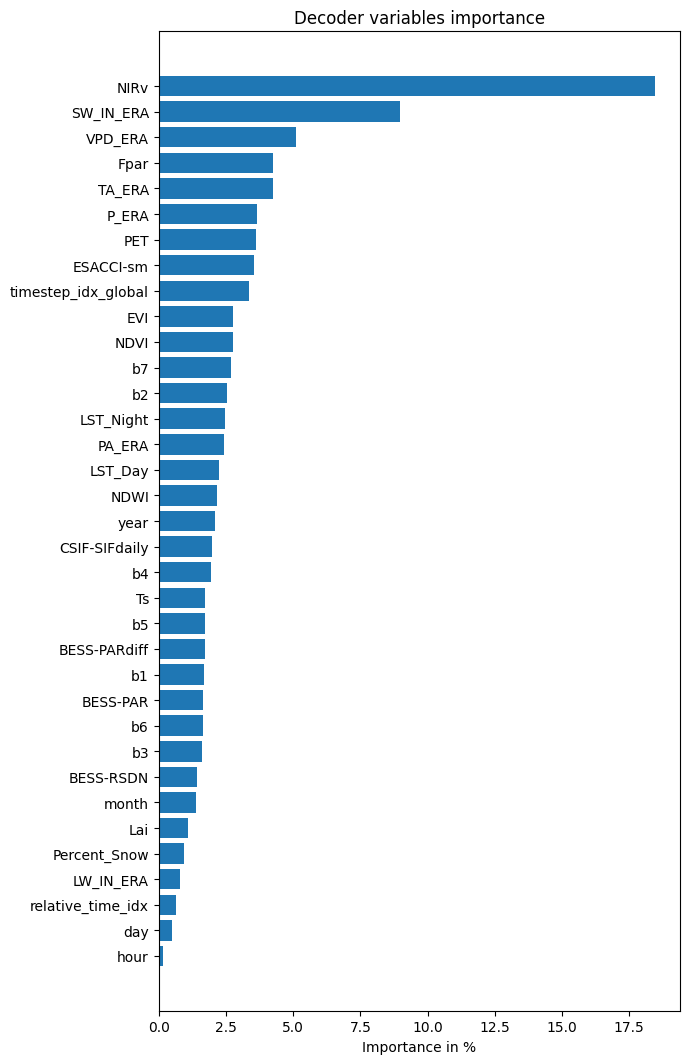

In [9]:
# Setup dataset
train_df, val_df, _ = get_splited_datasets(data_df, VAL_INDEX, TEST_INDEX)
train_df, val_df, _ = subset_data(train_df, val_df, None, SUBSET_LEN)
_, validation, _ = setup_tsdataset(train_df, val_df, None, ENCODER_LEN)
raw_predictions = best_tft.predict(validation, mode="raw",  show_progress_bar=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)